In [1]:
import os # File system operations
import re # Regular expressions
import pandas as pd # Tabular data
import numpy as np # Numerical data
pd.set_option('display.max_colwidth', None) # Show full file paths

# Don't use all of the GPU RAM
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
from tensorflow.keras import mixed_precision
from tensorflow import keras # ML
import tensorflow_addons as tfa # TQDM progress bar when training

BATCH_SIZE = 128

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from pathlib import Path # Pathing
from glob import glob # Finding files recursively
import matplotlib.pyplot as plt # Plotting
import seaborn as sns # Plotting
sns.set()
from tqdm.auto import tqdm # Progress bars
tqdm.pandas()

BASE_DIR = Path("/home/nick/dbox/EmbryoLabeling/Labelers/train")
folders = os.listdir(BASE_DIR)
folders = [f for f in folders if not re.match(r"M\d", f)]
files = []
for folder in folders:
    files_in_folder = pd.DataFrame(glob(f"{BASE_DIR}/{folder}/**/*.jpg", recursive=True), columns=["filename"])
    files_in_folder["class"] = folder
    files.append(files_in_folder)
df = pd.concat(files)
df["class"].value_counts()

/home/nick/.local/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Empty                5913
Blastocyst           2141
2pn                  1910
Morula               1643
2 Cell               1008
Syngamy               974
4 Cell                841
Compacting 8 cell     549
6 Cell                432
8 Cell                431
3 Cell                373
5 Cell                199
Name: class, dtype: int64

<AxesSubplot:>

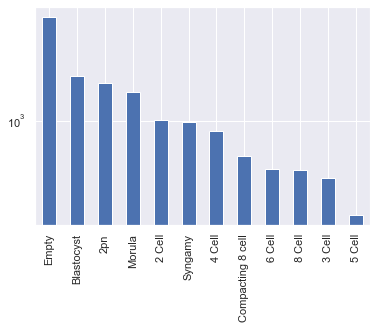

In [2]:
df["class"].value_counts().plot.bar(logy=True)

In [3]:
class_counts = df["class"].value_counts()
#mask = ~df["class"].isin(class_counts[class_counts > 10].index)
#df["class"][mask] = "Other"

In [4]:
#df["class"][~df["class"].isin(["Empty", "Morula"])] = "Other"
# Build training and validation dataframes. This gives us fine control over what we use for train & test
train_rows = []
validation_rows = []
for c in df["class"].unique():
    df_for_class = df[df["class"] == c].copy()
    if len(df_for_class) > 20:
        validation_sample = df_for_class.sample(min(round(.2*len(df_for_class)),500))
        validation_rows.append(validation_sample)
        train_sample = df_for_class.drop(validation_sample.index)
        # Accounting for training class imbalance
        # still leaving 20%. Might need more sophisticated f(x) here for class imbalance.
        train_sample = train_sample.sample(min(len(train_sample), round(len(df_for_class)),1500))
        train_rows.append(train_sample)
train_df = pd.concat(train_rows)
validation_df = pd.concat(validation_rows)
display(df)
display(train_df["class"].value_counts())
validation_df = validation_df.sample(frac=1)
display(validation_df["class"].value_counts())

,filename,class
0,/home/nick/dbox/EmbryoLabeling/Labelers/train/2 Cell/M776_S0087_W3_F0_1975.jpg,2 Cell
1,/home/nick/dbox/EmbryoLabeling/Labelers/train/2 Cell/M3169_S00737_W6_F0_2147.jpg,2 Cell
2,/home/nick/dbox/EmbryoLabeling/Labelers/train/2 Cell/M0776_S00635_W10_F0_1564.jpg,2 Cell
3,/home/nick/dbox/EmbryoLabeling/Labelers/train/2 Cell/M0776_S00635_W1_F0_1413.jpg,2 Cell
4,/home/nick/dbox/EmbryoLabeling/Labelers/train/2 Cell/M0776_S00534_W4_F0_1936.jpg,2 Cell
...,...,...
836,/home/nick/dbox/EmbryoLabeling/Labelers/train/4 Cell/M776_S0087_W4_F0_2775.jpg,4 Cell
837,/home/nick/dbox/EmbryoLabeling/Labelers/train/4 Cell/M0776_S00470_W4_F0_2987.jpg,4 Cell
838,/home/nick/dbox/EmbryoLabeling/Labelers/train/4 Cell/M0776_S00635_W7_F0_2619.jpg,4 Cell
839,/home/nick/dbox/EmbryoLabeling/Labelers/train/4 Cell/M0776_S00512_W1_F0_2851.jpg,4 Cell


2pn                  1500
Blastocyst           1500
Empty                1500
Morula               1314
2 Cell                806
Syngamy               779
4 Cell                673
Compacting 8 cell     439
6 Cell                346
8 Cell                345
3 Cell                298
5 Cell                159
Name: class, dtype: int64

Empty                500
Blastocyst           428
2pn                  382
Morula               329
2 Cell               202
Syngamy              195
4 Cell               168
Compacting 8 cell    110
8 Cell                86
6 Cell                86
3 Cell                75
5 Cell                40
Name: class, dtype: int64

In [5]:

datagen = keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
)


training = datagen.flow_from_dataframe(train_df, target_size=(299, 299), batch_size=BATCH_SIZE, shuffle=True)

# Don't shuffle validation, otherwise confusion_matrix won't work due to mismatch
validation = datagen.flow_from_dataframe(validation_df, target_size=(299, 299), batch_size=BATCH_SIZE, shuffle=False)

Found 9659 validated image filenames belonging to 12 classes.
Found 2601 validated image filenames belonging to 12 classes.


In [6]:
assert training.class_indices == validation.class_indices

In [7]:
list(training.class_indices.keys())

['2 Cell',
 '2pn',
 '3 Cell',
 '4 Cell',
 '5 Cell',
 '6 Cell',
 '8 Cell',
 'Blastocyst',
 'Compacting 8 cell',
 'Empty',
 'Morula',
 'Syngamy']

In [8]:
code2class = {v:k for k, v in training.class_indices.items()}
code2class

{0: '2 Cell',
 1: '2pn',
 2: '3 Cell',
 3: '4 Cell',
 4: '5 Cell',
 5: '6 Cell',
 6: '8 Cell',
 7: 'Blastocyst',
 8: 'Compacting 8 cell',
 9: 'Empty',
 10: 'Morula',
 11: 'Syngamy'}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

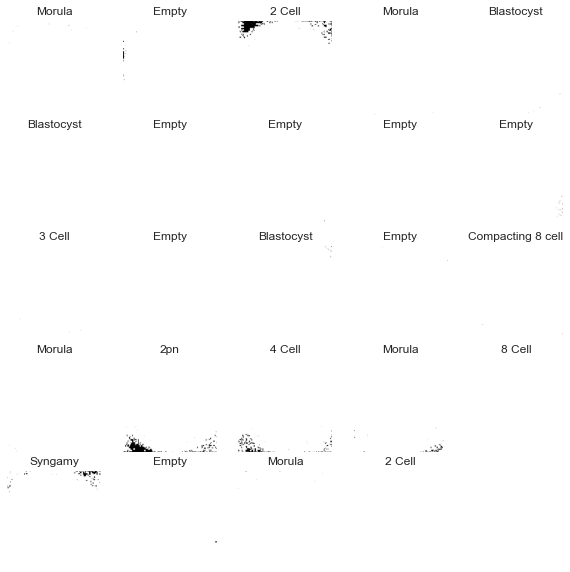

In [9]:
plt.figure(figsize=(10, 10))
images, labels = next(training)
for i in range(24):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    plt.title(code2class[labels[i].argmax()])
    plt.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

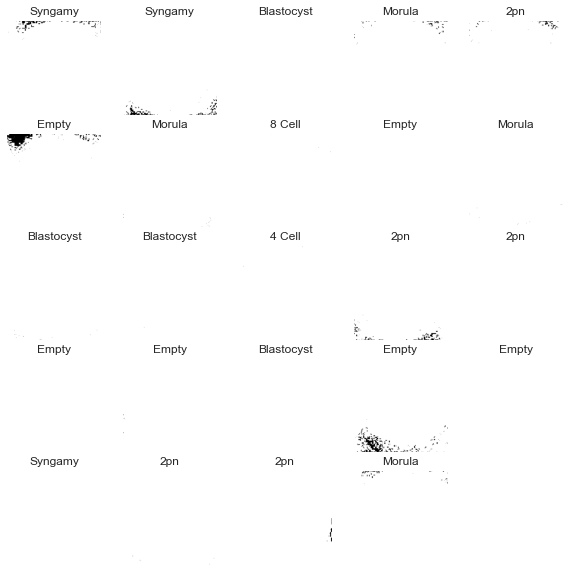

In [10]:
plt.figure(figsize=(10, 10))
images, labels = next(validation)
for i in range(min(24, len(labels))):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    plt.title(code2class[labels[i].argmax()])
    plt.axis("off")

In [11]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(299, 299, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(299, 299, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1./127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
#x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dense(512, activation='relu')(x)
outputs = keras.layers.Dense(len(code2class), activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary()

2022-06-10 20:45:10.571413: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-10 20:45:11.068512: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8529 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:42:00.0, compute capability: 7.5


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 299, 299, 3)       0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                             

In [12]:
%%time
training.reset()
validation.reset()
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()],
)


CPU times: user 16.1 ms, sys: 11 µs, total: 16.1 ms
Wall time: 15 ms


In [13]:

history = model.fit(training,
                    epochs=500,
                    verbose=0, # TQDMProgressBar logs out the info, so no need for the default logs
                    validation_data=validation,
                    callbacks=[
                        keras.callbacks.EarlyStopping(monitor='loss',patience=40, verbose=0),
                        tfa.callbacks.TQDMProgressBar()
                    ])

Training:   0%|           0/500 ETA: ?s,  ?epochs/s

Epoch 1/500


0/76           ETA: ?s - 

2022-06-10 20:45:16.072223: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400


Epoch 2/500


0/76           ETA: ?s - 

Epoch 3/500


0/76           ETA: ?s - 

Epoch 4/500


0/76           ETA: ?s - 

Epoch 5/500


0/76           ETA: ?s - 

Epoch 6/500


0/76           ETA: ?s - 

Epoch 7/500


0/76           ETA: ?s - 

Epoch 8/500


0/76           ETA: ?s - 

Epoch 9/500


0/76           ETA: ?s - 

Epoch 10/500


0/76           ETA: ?s - 

Epoch 11/500


0/76           ETA: ?s - 

Epoch 12/500


0/76           ETA: ?s - 

Epoch 13/500


0/76           ETA: ?s - 

Epoch 14/500


0/76           ETA: ?s - 

Epoch 15/500


0/76           ETA: ?s - 

Epoch 16/500


0/76           ETA: ?s - 

Epoch 17/500


0/76           ETA: ?s - 

Epoch 18/500


0/76           ETA: ?s - 

Epoch 19/500


0/76           ETA: ?s - 

Epoch 20/500


0/76           ETA: ?s - 

Epoch 21/500


0/76           ETA: ?s - 

Epoch 22/500


0/76           ETA: ?s - 

Epoch 23/500


0/76           ETA: ?s - 

Epoch 24/500


0/76           ETA: ?s - 

Epoch 25/500


0/76           ETA: ?s - 

Epoch 26/500


0/76           ETA: ?s - 

Epoch 27/500


0/76           ETA: ?s - 

Epoch 28/500


0/76           ETA: ?s - 

Epoch 29/500


0/76           ETA: ?s - 

Epoch 30/500


0/76           ETA: ?s - 

Epoch 31/500


0/76           ETA: ?s - 

Epoch 32/500


0/76           ETA: ?s - 

Epoch 33/500


0/76           ETA: ?s - 

Epoch 34/500


0/76           ETA: ?s - 

Epoch 35/500


0/76           ETA: ?s - 

Epoch 36/500


0/76           ETA: ?s - 

Epoch 37/500


0/76           ETA: ?s - 

Epoch 38/500


0/76           ETA: ?s - 

Epoch 39/500


0/76           ETA: ?s - 

Epoch 40/500


0/76           ETA: ?s - 

Epoch 41/500


0/76           ETA: ?s - 

Epoch 42/500


0/76           ETA: ?s - 

Epoch 43/500


0/76           ETA: ?s - 

Epoch 44/500


0/76           ETA: ?s - 

Epoch 45/500


0/76           ETA: ?s - 

Epoch 46/500


0/76           ETA: ?s - 

Epoch 47/500


0/76           ETA: ?s - 

Epoch 48/500


0/76           ETA: ?s - 

Epoch 49/500


0/76           ETA: ?s - 

Epoch 50/500


0/76           ETA: ?s - 

Epoch 51/500


0/76           ETA: ?s - 

Epoch 52/500


0/76           ETA: ?s - 

Epoch 53/500


0/76           ETA: ?s - 

Epoch 54/500


0/76           ETA: ?s - 

Epoch 55/500


0/76           ETA: ?s - 

Epoch 56/500


0/76           ETA: ?s - 

Epoch 57/500


0/76           ETA: ?s - 

Epoch 58/500


0/76           ETA: ?s - 

Epoch 59/500


0/76           ETA: ?s - 

Epoch 60/500


0/76           ETA: ?s - 

Epoch 61/500


0/76           ETA: ?s - 

Epoch 62/500


0/76           ETA: ?s - 

Epoch 63/500


0/76           ETA: ?s - 

Epoch 64/500


0/76           ETA: ?s - 

Epoch 65/500


0/76           ETA: ?s - 

Epoch 66/500


0/76           ETA: ?s - 

Epoch 67/500


0/76           ETA: ?s - 

Epoch 68/500


0/76           ETA: ?s - 

Epoch 69/500


0/76           ETA: ?s - 

Epoch 70/500


0/76           ETA: ?s - 

Epoch 71/500


0/76           ETA: ?s - 

Epoch 72/500


0/76           ETA: ?s - 

Epoch 73/500


0/76           ETA: ?s - 

Epoch 74/500


0/76           ETA: ?s - 

Epoch 75/500


0/76           ETA: ?s - 

Epoch 76/500


0/76           ETA: ?s - 

Epoch 77/500


0/76           ETA: ?s - 

Epoch 78/500


0/76           ETA: ?s - 

Epoch 79/500


0/76           ETA: ?s - 

Epoch 80/500


0/76           ETA: ?s - 

Epoch 81/500


0/76           ETA: ?s - 

Epoch 82/500


0/76           ETA: ?s - 

Epoch 83/500


0/76           ETA: ?s - 

Epoch 84/500


0/76           ETA: ?s - 

Epoch 85/500


0/76           ETA: ?s - 

Epoch 86/500


0/76           ETA: ?s - 

Epoch 87/500


0/76           ETA: ?s - 

Epoch 88/500


0/76           ETA: ?s - 

Epoch 89/500


0/76           ETA: ?s - 

Epoch 90/500


0/76           ETA: ?s - 

Epoch 91/500


0/76           ETA: ?s - 

Epoch 92/500


0/76           ETA: ?s - 

Epoch 93/500


0/76           ETA: ?s - 

Epoch 94/500


0/76           ETA: ?s - 

Epoch 95/500


0/76           ETA: ?s - 

Epoch 96/500


0/76           ETA: ?s - 

Epoch 97/500


0/76           ETA: ?s - 

Epoch 98/500


0/76           ETA: ?s - 

Epoch 99/500


0/76           ETA: ?s - 

Epoch 100/500


0/76           ETA: ?s - 

Epoch 101/500


0/76           ETA: ?s - 

Epoch 102/500


0/76           ETA: ?s - 

Epoch 103/500


0/76           ETA: ?s - 

Epoch 104/500


0/76           ETA: ?s - 

Epoch 105/500


0/76           ETA: ?s - 

Epoch 106/500


0/76           ETA: ?s - 

Epoch 107/500


0/76           ETA: ?s - 

Epoch 108/500


0/76           ETA: ?s - 

Epoch 109/500


0/76           ETA: ?s - 

Epoch 110/500


0/76           ETA: ?s - 

Epoch 111/500


0/76           ETA: ?s - 

Epoch 112/500


0/76           ETA: ?s - 

Epoch 113/500


0/76           ETA: ?s - 

Epoch 114/500


0/76           ETA: ?s - 

Epoch 115/500


0/76           ETA: ?s - 

Epoch 116/500


0/76           ETA: ?s - 

Epoch 117/500


0/76           ETA: ?s - 

Epoch 118/500


0/76           ETA: ?s - 

Epoch 119/500


0/76           ETA: ?s - 

Epoch 120/500


0/76           ETA: ?s - 

Epoch 121/500


0/76           ETA: ?s - 

Epoch 122/500


0/76           ETA: ?s - 

Epoch 123/500


0/76           ETA: ?s - 

Epoch 124/500


0/76           ETA: ?s - 

Epoch 125/500


0/76           ETA: ?s - 

Epoch 126/500


0/76           ETA: ?s - 

Epoch 127/500


0/76           ETA: ?s - 

Epoch 128/500


0/76           ETA: ?s - 

Epoch 129/500


0/76           ETA: ?s - 

Epoch 130/500


0/76           ETA: ?s - 

Epoch 131/500


0/76           ETA: ?s - 

Epoch 132/500


0/76           ETA: ?s - 

Epoch 133/500


0/76           ETA: ?s - 

Epoch 134/500


0/76           ETA: ?s - 

Epoch 135/500


0/76           ETA: ?s - 

Epoch 136/500


0/76           ETA: ?s - 

Epoch 137/500


0/76           ETA: ?s - 

Epoch 138/500


0/76           ETA: ?s - 

Epoch 139/500


0/76           ETA: ?s - 

Epoch 140/500


0/76           ETA: ?s - 

Epoch 141/500


0/76           ETA: ?s - 

Epoch 142/500


0/76           ETA: ?s - 

Epoch 143/500


0/76           ETA: ?s - 

Epoch 144/500


0/76           ETA: ?s - 

Epoch 145/500


0/76           ETA: ?s - 

Epoch 146/500


0/76           ETA: ?s - 

Epoch 147/500


0/76           ETA: ?s - 

Epoch 148/500


0/76           ETA: ?s - 

Epoch 149/500


0/76           ETA: ?s - 

Epoch 150/500


0/76           ETA: ?s - 

Epoch 151/500


0/76           ETA: ?s - 

Epoch 152/500


0/76           ETA: ?s - 

Epoch 153/500


0/76           ETA: ?s - 

Epoch 154/500


0/76           ETA: ?s - 

Epoch 155/500


0/76           ETA: ?s - 

Epoch 156/500


0/76           ETA: ?s - 

Epoch 157/500


0/76           ETA: ?s - 

Epoch 158/500


0/76           ETA: ?s - 

Epoch 159/500


0/76           ETA: ?s - 

Epoch 160/500


0/76           ETA: ?s - 

Epoch 161/500


0/76           ETA: ?s - 

Epoch 162/500


0/76           ETA: ?s - 

Epoch 163/500


0/76           ETA: ?s - 

Epoch 164/500


0/76           ETA: ?s - 

Epoch 165/500


0/76           ETA: ?s - 

Epoch 166/500


0/76           ETA: ?s - 

Epoch 167/500


0/76           ETA: ?s - 

Epoch 168/500


0/76           ETA: ?s - 

Epoch 169/500


0/76           ETA: ?s - 

Epoch 170/500


0/76           ETA: ?s - 

Epoch 171/500


0/76           ETA: ?s - 

Epoch 172/500


0/76           ETA: ?s - 

Epoch 173/500


0/76           ETA: ?s - 

Epoch 174/500


0/76           ETA: ?s - 

Epoch 175/500


0/76           ETA: ?s - 

Epoch 176/500


0/76           ETA: ?s - 

Epoch 177/500


0/76           ETA: ?s - 

Epoch 178/500


0/76           ETA: ?s - 

Epoch 179/500


0/76           ETA: ?s - 

Epoch 180/500


0/76           ETA: ?s - 

Epoch 181/500


0/76           ETA: ?s - 

Epoch 182/500


0/76           ETA: ?s - 

Epoch 183/500


0/76           ETA: ?s - 

Epoch 184/500


0/76           ETA: ?s - 

Epoch 185/500


0/76           ETA: ?s - 

Epoch 186/500


0/76           ETA: ?s - 

Epoch 187/500


0/76           ETA: ?s - 

Epoch 188/500


0/76           ETA: ?s - 

Epoch 189/500


0/76           ETA: ?s - 

Epoch 190/500


0/76           ETA: ?s - 

Epoch 191/500


0/76           ETA: ?s - 

Epoch 192/500


0/76           ETA: ?s - 

Epoch 193/500


0/76           ETA: ?s - 

Epoch 194/500


0/76           ETA: ?s - 

Epoch 195/500


0/76           ETA: ?s - 

Epoch 196/500


0/76           ETA: ?s - 

Epoch 197/500


0/76           ETA: ?s - 

Epoch 198/500


0/76           ETA: ?s - 

Epoch 199/500


0/76           ETA: ?s - 

Epoch 200/500


0/76           ETA: ?s - 

Epoch 201/500


0/76           ETA: ?s - 

Epoch 202/500


0/76           ETA: ?s - 

Epoch 203/500


0/76           ETA: ?s - 

Epoch 204/500


0/76           ETA: ?s - 

Epoch 205/500


0/76           ETA: ?s - 

Epoch 206/500


0/76           ETA: ?s - 

Epoch 207/500


0/76           ETA: ?s - 

Epoch 208/500


0/76           ETA: ?s - 

Epoch 209/500


0/76           ETA: ?s - 

Epoch 210/500


0/76           ETA: ?s - 

Epoch 211/500


0/76           ETA: ?s - 

Epoch 212/500


0/76           ETA: ?s - 

Epoch 213/500


0/76           ETA: ?s - 

Epoch 214/500


0/76           ETA: ?s - 

Epoch 215/500


0/76           ETA: ?s - 

Epoch 216/500


0/76           ETA: ?s - 

Epoch 217/500


0/76           ETA: ?s - 

Epoch 218/500


0/76           ETA: ?s - 

Epoch 219/500


0/76           ETA: ?s - 

Epoch 220/500


0/76           ETA: ?s - 

Epoch 221/500


0/76           ETA: ?s - 

Epoch 222/500


0/76           ETA: ?s - 

Epoch 223/500


0/76           ETA: ?s - 

Epoch 224/500


0/76           ETA: ?s - 

Epoch 225/500


0/76           ETA: ?s - 

Epoch 226/500


0/76           ETA: ?s - 

Epoch 227/500


0/76           ETA: ?s - 

Epoch 228/500


0/76           ETA: ?s - 

Epoch 229/500


0/76           ETA: ?s - 

Epoch 230/500


0/76           ETA: ?s - 

Epoch 231/500


0/76           ETA: ?s - 

Epoch 232/500


0/76           ETA: ?s - 

Epoch 233/500


0/76           ETA: ?s - 

Epoch 234/500


0/76           ETA: ?s - 

Epoch 235/500


0/76           ETA: ?s - 

Epoch 236/500


0/76           ETA: ?s - 

Epoch 237/500


0/76           ETA: ?s - 

Epoch 238/500


0/76           ETA: ?s - 

Epoch 239/500


0/76           ETA: ?s - 

Epoch 240/500


0/76           ETA: ?s - 

Epoch 241/500


0/76           ETA: ?s - 

Epoch 242/500


0/76           ETA: ?s - 

Epoch 243/500


0/76           ETA: ?s - 

Epoch 244/500


0/76           ETA: ?s - 

Epoch 245/500


0/76           ETA: ?s - 

Epoch 246/500


0/76           ETA: ?s - 

Epoch 247/500


0/76           ETA: ?s - 

Epoch 248/500


0/76           ETA: ?s - 

Epoch 249/500


0/76           ETA: ?s - 

Epoch 250/500


0/76           ETA: ?s - 

Epoch 251/500


0/76           ETA: ?s - 

Epoch 252/500


0/76           ETA: ?s - 

Epoch 253/500


0/76           ETA: ?s - 

Epoch 254/500


0/76           ETA: ?s - 

Epoch 255/500


0/76           ETA: ?s - 

Epoch 256/500


0/76           ETA: ?s - 

Epoch 257/500


0/76           ETA: ?s - 

Epoch 258/500


0/76           ETA: ?s - 

Epoch 259/500


0/76           ETA: ?s - 

Epoch 260/500


0/76           ETA: ?s - 

Epoch 261/500


0/76           ETA: ?s - 

Epoch 262/500


0/76           ETA: ?s - 

Epoch 263/500


0/76           ETA: ?s - 

Epoch 264/500


0/76           ETA: ?s - 

Epoch 265/500


0/76           ETA: ?s - 

Epoch 266/500


0/76           ETA: ?s - 

Epoch 267/500


0/76           ETA: ?s - 

Epoch 268/500


0/76           ETA: ?s - 

Epoch 269/500


0/76           ETA: ?s - 

Epoch 270/500


0/76           ETA: ?s - 

Epoch 271/500


0/76           ETA: ?s - 

Epoch 272/500


0/76           ETA: ?s - 

Epoch 273/500


0/76           ETA: ?s - 

Epoch 274/500


0/76           ETA: ?s - 

Epoch 275/500


0/76           ETA: ?s - 

Epoch 276/500


0/76           ETA: ?s - 

Epoch 277/500


0/76           ETA: ?s - 

Epoch 278/500


0/76           ETA: ?s - 

Epoch 279/500


0/76           ETA: ?s - 

Epoch 280/500


0/76           ETA: ?s - 

Epoch 281/500


0/76           ETA: ?s - 

Epoch 282/500


0/76           ETA: ?s - 

Epoch 283/500


0/76           ETA: ?s - 

Epoch 284/500


0/76           ETA: ?s - 

Epoch 285/500


0/76           ETA: ?s - 

Epoch 286/500


0/76           ETA: ?s - 

Epoch 287/500


0/76           ETA: ?s - 

Epoch 288/500


0/76           ETA: ?s - 

Epoch 289/500


0/76           ETA: ?s - 

Epoch 290/500


0/76           ETA: ?s - 

Epoch 291/500


0/76           ETA: ?s - 

Epoch 292/500


0/76           ETA: ?s - 

Epoch 293/500


0/76           ETA: ?s - 

Epoch 294/500


0/76           ETA: ?s - 

Epoch 295/500


0/76           ETA: ?s - 

<AxesSubplot:>

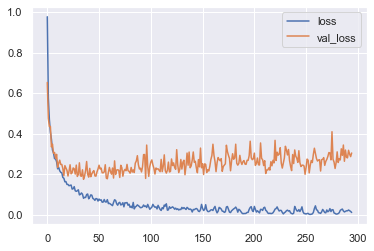

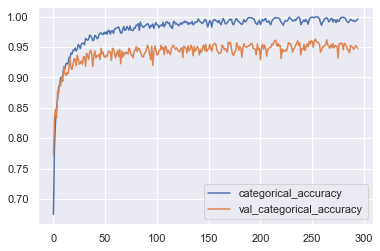

In [14]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['categorical_accuracy', 'val_categorical_accuracy']].plot()

In [15]:
y_pred = model.predict(validation)

21/21 [==============================] - 9s 421ms/step


In [16]:
predicted_codes = y_pred.argmax(axis=1)
confidence = pd.Series(y_pred.max(axis=1))
confidence.describe()

count    2601.000000
mean        0.986892
std         0.060246
min         0.479010
25%         0.999994
50%         1.000000
75%         1.000000
max         1.000000
dtype: float64

In [17]:
validation_df["predicted_class"] = [code2class[c] for c in predicted_codes]
validation_df["confidence"] = confidence
validation_df

,filename,class,predicted_class,confidence
953,/home/nick/dbox/EmbryoLabeling/Labelers/train/Syngamy/M0776_S00534_W4_F0_85.jpg,Syngamy,Syngamy,1.000000
665,/home/nick/dbox/EmbryoLabeling/Labelers/train/Syngamy/M0776_S00512_W3_F0_279.jpg,Syngamy,Syngamy,1.000000
531,/home/nick/dbox/EmbryoLabeling/Labelers/train/Blastocyst/M3169_S00668_W8_F0_6097.jpg,Blastocyst,Blastocyst,0.939220
79,/home/nick/dbox/EmbryoLabeling/Labelers/train/Morula/M0776_S00512_W8_F0_5451.jpg,Morula,Morula,1.000000
1260,/home/nick/dbox/EmbryoLabeling/Labelers/train/2pn/M0776_S00512_W8_F0_1320.jpg,2pn,2pn,1.000000
...,...,...,...,...
456,/home/nick/dbox/EmbryoLabeling/Labelers/train/2pn/M3169_S00668_W14_F0_1195.jpg,2pn,2pn,0.996781
946,/home/nick/dbox/EmbryoLabeling/Labelers/train/2 Cell/M3169_S00737_W1_F0_2349.jpg,2 Cell,2 Cell,0.999999
713,/home/nick/dbox/EmbryoLabeling/Labelers/train/Syngamy/M0831_S00659_W1_F0_166.jpg,Syngamy,Syngamy,1.000000
799,/home/nick/dbox/EmbryoLabeling/Labelers/train/4 Cell/M0776_S00512_W5_F0_2270.jpg,4 Cell,4 Cell,1.000000


In [18]:
validation_df.groupby("class").confidence.median()

class
2 Cell               1.0
2pn                  1.0
3 Cell               1.0
4 Cell               1.0
5 Cell               1.0
6 Cell               1.0
8 Cell               1.0
Blastocyst           1.0
Compacting 8 cell    1.0
Empty                1.0
Morula               1.0
Syngamy              1.0
Name: confidence, dtype: float32

                   precision    recall  f1-score   support

           2 Cell       0.92      0.97      0.95       202
              2pn       0.94      0.99      0.96       382
           3 Cell       0.87      0.81      0.84        75
           4 Cell       0.99      0.90      0.94       168
           5 Cell       0.77      0.82      0.80        40
           6 Cell       0.81      0.90      0.85        86
           8 Cell       0.94      0.85      0.89        86
       Blastocyst       0.99      0.96      0.98       428
Compacting 8 cell       0.93      0.75      0.83       110
            Empty       1.00      1.00      1.00       500
           Morula       0.88      0.98      0.93       329
          Syngamy       0.99      0.88      0.93       195

         accuracy                           0.95      2601
        macro avg       0.92      0.90      0.91      2601
     weighted avg       0.95      0.95      0.95      2601



Text(30.453124999999993, 0.5, 'True')

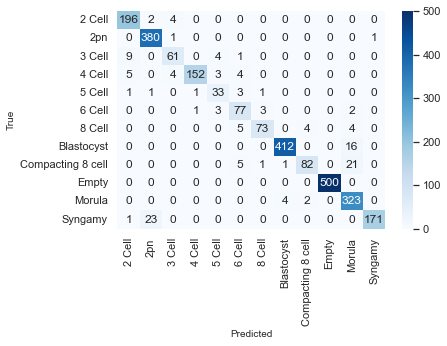

In [19]:
print(classification_report(validation_df["class"], validation_df["predicted_class"]))
labels = list(training.class_indices.keys())
s = sns.heatmap(
    confusion_matrix(validation_df["class"], validation_df["predicted_class"]),
    annot=True,
    cmap='Blues',
    fmt="g",
    xticklabels=labels,
    yticklabels=labels
)
s.set_xlabel('Predicted', fontsize=10)
s.set_ylabel('True', fontsize=10)

In [20]:
model.save(f"models/dense_{len(code2class)}_class.h5")